NOTE : The dataset that I downloaded from kaggle has only 4.3 lakh data points hwereas in the research I noticed that people have used the dataset with 1.3 milllion datapoints.

I could not find a way to handle bundle values in item_name.
Filling brand_name with imputation will be performed in the modelling part.
I could not find a way to avoid information leakage of price through name feature

In [1]:
from google.colab import drive
drive.mount("/content/drive",force_remount=True)

Mounted at /content/drive


In [ ]:
#Install the package
!apt-get install p7zip-full

Reading package lists... Done
Building dependency tree       
Reading state information... Done
p7zip-full is already the newest version (16.02+dfsg-6).
0 upgraded, 0 newly installed, 0 to remove and 14 not upgraded.


In [3]:
import os
os.chdir("/content/drive/My Drive/mercari price suggestion challenge")

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import nltk
from tqdm import tqdm
from wordcloud import WordCloud,STOPWORDS
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.preprocessing import StandardScaler

nltk.download('vader_lexicon')
nltk.download('punkt')
nltk.download('stopwords')


/usr/local/lib/python3.6/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
!p7zip -d train.tsv.7z

/usr/bin/p7zip: cannot read train.tsv.7z


###Exploratory Data Analysis**

In [146]:
test = pd.read_csv('test_stg2.tsv', sep='\t')
test.head()

,test_id,name,item_condition_id,category_name,brand_name,shipping,item_description
0,0,"Breast cancer ""I fight like a girl"" ring",1,Women/Jewelry/Rings,NaN,1,Size 7
1,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers",1,Other/Office supplies/Shipping Supplies,NaN,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers Lined..."
2,2,Coach bag,1,Vintage & Collectibles/Bags and Purses/Handbag,Coach,1,Brand new coach bag. Bought for [rm] at a Coac...
3,3,Floral Kimono,2,Women/Sweaters/Cardigan,NaN,0,-floral kimono -never worn -lightweight and pe...
4,4,Life after Death,3,Other/Books/Religion & Spirituality,NaN,1,Rediscovering life after the loss of a loved o...


In [147]:
test.shape

(3460725, 7)

In [53]:
data=pd.read_csv("train.csv")
data

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity
...,...,...,...,...,...,...,...,...
1482530,1482530,Free People Inspired Dress,2,Women/Dresses/Mid-Calf,Free People,20.0,1,"Lace, says size small but fits medium perfectl..."
1482531,1482531,Little mermaid handmade dress,2,Kids/Girls 2T-5T/Dresses,Disney,14.0,0,Little mermaid handmade dress never worn size 2t
1482532,1482532,21 day fix containers and eating plan,2,Sports & Outdoors/Exercise/Fitness accessories,NaN,12.0,0,"Used once or twice, still in great shape."
1482533,1482533,World markets lanterns,3,Home/Home Décor/Home Décor Accents,NaN,45.0,1,There is 2 of each one that you see! So 2 red ...


Dataset contains around 430000  datapoints and 8 features.Features are

*   train_id : Unique Id to identify a Data Point
*   name : Name of the Product in short
*   Item_condition_id: It is an ordinal feature ranging between 1-5,1 being best and 5 worst.
*   Category_Name : The Category under which the Product falls into. It is in a hierarchical form of 3 subcategories.It is also a text feature.
*   Brand Name : Name of the Brand the Product belongs to
*   Price : The Price of the Product
*   Shipping : A boolean variable indicating whether the Shipping price will be paid by seller or buyer
*   Item Description : A text summary describing the product in much detail.

We can see that some features have NaN values like brand and also in item_description missing is shown by "No description yet".Let's check which all features have NaN values and how many.

In [54]:
#check which all features contain NaN values
nan_values_trainid=data['train_id'].isnull().sum()
nan_values_name=data['name'].isnull().sum()
nan_values_item_condition=data['item_condition_id'].isnull().sum()
nan_values_category_name=data['category_name'].isnull().sum()
nan_values_brand_name=data['brand_name'].isnull().sum()
nan_values_price=data['price'].isnull().sum()
nan_values_shipping=data['shipping'].isnull().sum()
nan_values_item_description=data['item_description'].isnull().sum()

In [55]:
print(
    nan_values_trainid,
    nan_values_name,
    nan_values_item_condition,
    nan_values_category_name,
    nan_values_brand_name,
    nan_values_price,
    nan_values_shipping,
    nan_values_item_description)

0 0 0 6327 632682 0 0 4


So the columns category_name,brand_name and item_description have NaN values.Category_name has 6327 missing values and brand_name has around 6 lakh 32 thousand missing features.Also we have noticed above that item_description has "no description yet",lets see how many datapoints have this value as item_description.

In [56]:
sum_no_description_yet=(data['item_description']=="No description yet").sum()
sum_no_description_yet

82489

So 82489 datapoints have "no description yet" and 4 have NaN values,thus 82493 have no values in item_description.Let's start with feature wise EDA 

### EDA on Price

In [57]:
data['price'].describe()

count    1.482535e+06
mean     2.673752e+01
std      3.858607e+01
min      0.000000e+00
25%      1.000000e+01
50%      1.700000e+01
75%      2.900000e+01
max      2.009000e+03
Name: price, dtype: float64

Some items are price 0 which might cause some error.Also  75% of the items are price below  29 dollars so most of the items are priced less and few items are price very high as maximum is $ 2009.Let's plot its pdf and see its description.


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


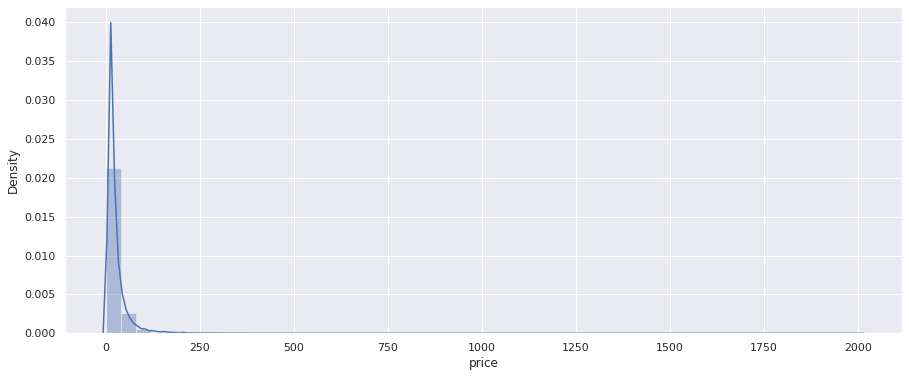

In [58]:
sns.set(rc={'figure.figsize':(15,6)})
sns.distplot(data['price'])
plt.show()

We can see that the destribution of price is left skewed and most of the values are less than 100.We also know know that 75 percent of the prices have value less than 29 dollars but the maximum is 2009 dollars,lets see how many items have very high prices.

In [59]:
for i in range(75,101):
  print(np.percentile(data['price'],i))

29.0
30.0
31.0
31.0
33.0
34.0
35.0
36.0
38.0
39.0
40.0
42.0
44.0
46.0
49.0
51.0
55.0
58.0
62.0
67.0
75.0
85.0
99.0
122.0
170.0
2009.0


We can see that 99 percent of items have price less than 170 dollars but the maximum is 2009 dollars,lets dig further

In [60]:
for i in range(990,1001):
  print(np.percentile(data['price'],i*0.1))

170.0
180.0
189.0
200.0
210.0
230.3300000000745
256.0
286.0
340.0
450.0
2009.0


Thus we can say that 99.9 percent items have price less than 450 dollars,lets dig in further

In [61]:
for i in range(9990,10001):
  print(np.percentile(data['price'],i*0.01))

450.0
459.0
490.0
509.0
556.0
603.1990000000224
659.9864000000525
734.0
838.479600000428
1015.0
2009.0


So 99.99 percent point are less than 1015,for it would be better to remove the points which are price higher than 2000 as they are outliers and Mercari also does not allow items to be priced above 2000 dollars.

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


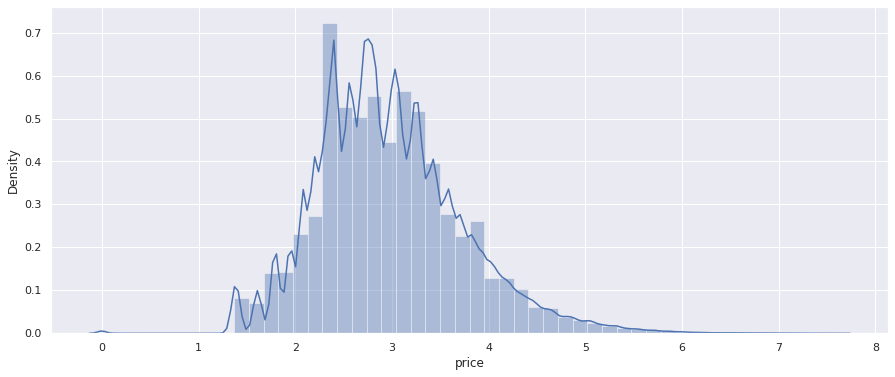

In [62]:
sns.set(rc={'figure.figsize':(15,6)})
sns.distplot(np.log(data['price']+1))
plt.show()

We can see that the destribution of np(log['price']+1) is similar to a bell curve which would also be useful in future,also because metric is RMSLE.We can also see in the graph that there is a line left of zero thus there are items with negative prices.Lets check how many items have price less than zero.

In [63]:
negative_prices=len(data[data.price<0])
print("Number of prices which have negative prices are ",negative_prices)
zero_price=len(data[data.price==0])
print("Number of item which are priced zero are ",zero_price)

Number of prices which have negative prices are  0
Number of item which are priced zero are  874


Thus there are no item with negative prices but 874 item have price equal to zero.It is also known from research that range of price allowed in Mercari is between 5 dollars to 2000 dollars.Lets check how many values don't fit in this range.

In [64]:
price_less_than_range=len(data[data.price<=5])
price_greater_than_range=len(data[data.price>2000])
not_inrange_prices=price_less_than_range + price_greater_than_range
print("Number of prices which have negative prices are ",not_inrange_prices)

Number of prices which have negative prices are  67221


These item which have prices that are not within the range allowed can be removed as they are outliers.

# EDA on item_condition


*   It is an ordinal feature indicatating the condition of item where  1 represents that item is in good condition and it gets poor as condition values goes from 1 to 5



In [65]:
data['item_condition_id'].unique()

array([3, 1, 2, 4, 5])

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


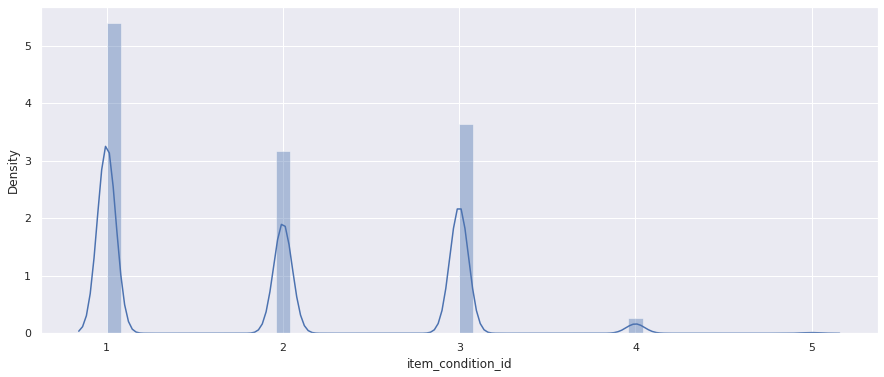

In [66]:
sns.set(rc={'figure.figsize':(15,6)})
sns.distplot(data["item_condition_id"]) 
plt.show();

It is clear that item with condition_id=1 occur the most than the items with condition_id =3 and items with condition_id=5 occur the least

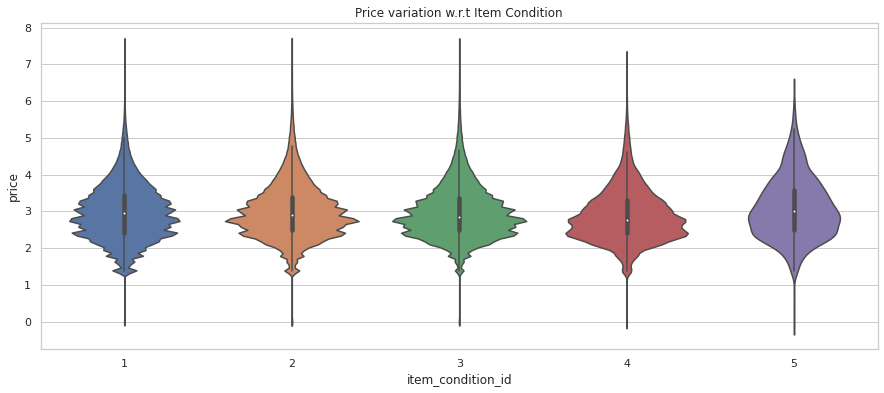

In [67]:
sns.set(style='whitegrid')
plt.figure(figsize=(15,6))
sns.violinplot(x=data['item_condition_id'], y=np.log(data['price']+1))
plt.title('Price variation w.r.t Item Condition')
plt.show()

It can be observed that the aveage prices of all conditions is almost same,item with high prices usually belong to category 1,2 and 3 and items with lowest prices belong to category 5.

##EDA on Brand_name


*   Shows the name of brand the item is of
*   MOst of the data points have "NaN" as brand_name



In [68]:
#lets check what percent of items have "NaN" brand names
count_unbranded=data['brand_name'].isnull().sum()
percent_unbranded=(count_unbranded/data.shape[0])*100
print("Number of points which do not have brand name ",count_unbranded)
print("Percentage of points which do not have brand name ",percent_unbranded)

Number of points which do not have brand name  632682
Percentage of points which do not have brand name  42.675687251902986


Number of Unique brands 4809


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


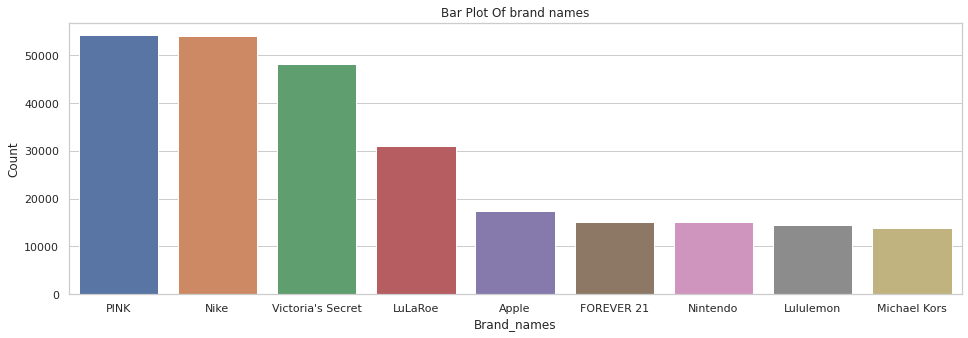

In [69]:
count=data['brand_name'].value_counts()
print("Number of Unique brands",len(count))
plt.figure(figsize=(16,5))
sns.barplot(count.index[0:9],count[0:9])
plt.title("Bar Plot Of brand names")
plt.xlabel('Brand_names')
plt.ylabel('Count')
plt.show()


There are 4809 unique brandsand top brands are pink and nike,although around 63 thousand items do not have brands,lets first check distribution of price between these brands and then price destribution between branded and unbranded products

In [70]:
#Table of Brand Name along with the Average Price Per Brand
brands_df = pd.DataFrame(data.groupby('brand_name', as_index=False).agg({'price': 'mean'}))

print(brands_df.shape)
brands_df.head(10)

(4809, 2)


,brand_name,price
0,!iT Jeans,16.000000
1,% Pure,16.344262
2,10.Deep,17.333333
3,191 Unlimited,36.000000
4,1byone,51.000000
5,21men,12.166667
6,24/7 Comfort Apparel,47.000000
7,2K Games,9.000000
8,2XU,32.000000
9,3.1 Phillip Lim,141.619048


We can see that price depends on brand_name a lot as average price of 3M is 1.86 and that 3.1 Phillip Lim is 4.75.

In [71]:
#filling missing brand values as "missing"
data['brand_name'] = data['brand_name'].fillna('missing').astype('category')
print(data.brand_name.isnull().sum())

0


In [72]:
count_unbranded=data.loc[data['brand_name']=="missing"]
count_branded=data.loc[data['brand_name']!="missing"]

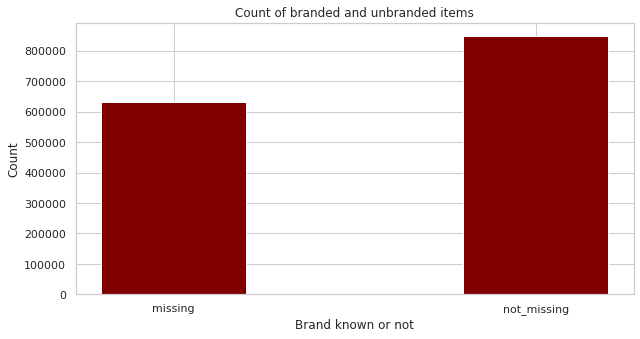

Percentage of item with known brands  57.32431274809701
Percentage of item with unknown brands  42.675687251902986


In [73]:
brand_data= {'missing':count_unbranded.shape[0], 'not_missing':count_branded.shape[0]} 
courses = list(brand_data.keys()) 
values = list(brand_data.values()) 
   
fig = plt.figure(figsize = (10, 5)) 
  
# creating the bar plot 
plt.bar(courses, values, color ='maroon',  
        width = 0.4) 
  
plt.xlabel("Brand known or not") 
plt.ylabel("Count") 
plt.title("Count of branded and unbranded items") 
plt.show() 


print("Percentage of item with known brands ",(count_branded.shape[0]/data.shape[0])*100)
print("Percentage of item with unknown brands ",(count_unbranded.shape[0]/data.shape[0])*100)

There are more items with known brands than unknown brands

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


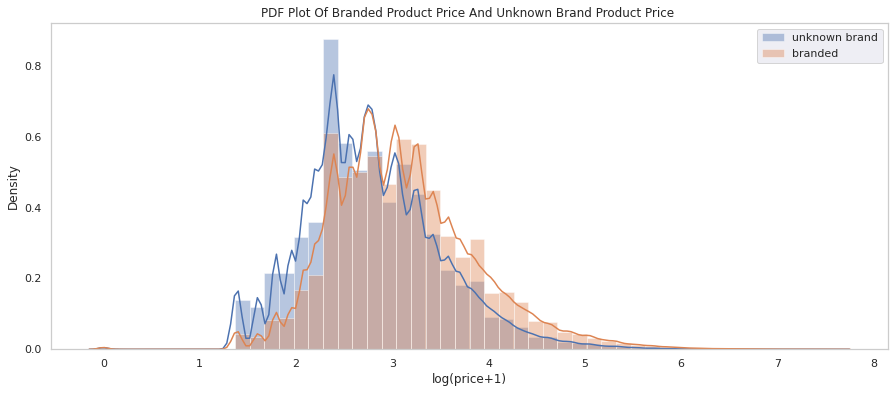

In [74]:
sns.distplot(np.log(count_unbranded['price']+1),label='unknown brand')
sns.distplot(np.log(count_branded['price']+1),label='branded')
plt.title('PDF Plot Of Branded Product Price And Unknown Brand Product Price ')
sns.set(rc={'figure.figsize':(15,6)})
plt.xlabel('log(price+1)')
plt.grid()
plt.legend()
plt.show()

Price of item whose brand is known is greater than of those whose brand is not known.So it goes with the intuition that branded items are usually costlier than unbranded item.

##EDA on Shipping

It is a boolen feature which indicates who pays shipping cost

*   0 : buyer pays for shipping
*   1 : seller pays for shipping



In [75]:
data['shipping'].unique()

array([1, 0])

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


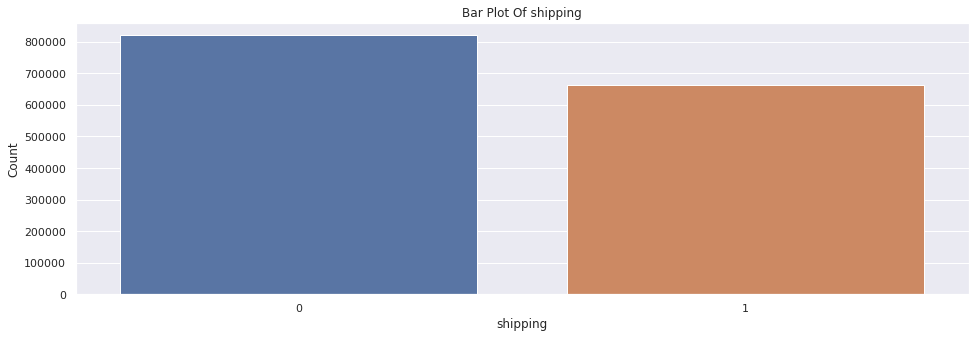

In [76]:
count=data['shipping'].value_counts()
plt.figure(figsize=(16,5))
sns.barplot(count.index,count)
plt.title("Bar Plot Of shipping")
plt.xlabel('shipping')
plt.ylabel('Count')
plt.show()

There are more items for which the shipping cost is not paid by the seller than those for which shipping cost is paid by the seller

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


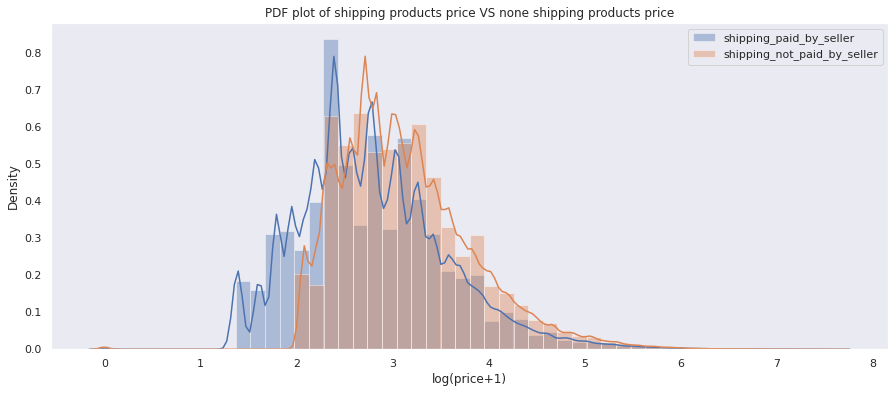

In [77]:
shipping_paid_by_seller=np.log(data.loc[data['shipping']==1,'price']+1)
shipping_not_paid_by_seller=np.log(data.loc[data['shipping']==0,'price']+1)
sns.distplot(shipping_paid_by_seller,label='shipping_paid_by_seller')
sns.distplot(shipping_not_paid_by_seller,label='shipping_not_paid_by_seller')
sns.set(rc={'figure.figsize':(15,6)})
plt.title('PDF plot of shipping products price VS none shipping products price')
plt.xlabel("log(price+1)")
plt.grid()
plt.legend()
plt.show()


The average price of item for which the shipping is not paid by seller is higher than those whose shipping price is paid by the seller.It is actually inverse of the basic understanding that items which are high priced have high profit and sellers mange the shipping cost

##EDA on Category_name

1.   It shows the category of the item






In [78]:
#it had some missing values so lets fill them
# Filling all the Missing/Null Values with "missing" value
data["category_name"].fillna("missing", inplace=True)
print("Number of Missing Values in Category Name : ", data.category_name.isnull().sum())

Number of Missing Values in Category Name :  0


In [79]:
data['category_name'][1:10]

1    Electronics/Computers & Tablets/Components & P...
2                          Women/Tops & Blouses/Blouse
3                   Home/Home Décor/Home Décor Accents
4                              Women/Jewelry/Necklaces
5                                    Women/Other/Other
6                             Women/Swimwear/Two-Piece
7                      Sports & Outdoors/Apparel/Girls
8                      Sports & Outdoors/Apparel/Girls
9             Vintage & Collectibles/Collectibles/Doll
Name: category_name, dtype: object

   we can see that it is in a hierarchical form of multiple subcategories.Lets seperate them into subcategories

In [80]:
#Lets brake the category feature into 3 parts.
data['main_category'],data['sub_category1'],data['sub_category2']=data['category_name'].str.split("/",2).str
data

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  


,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,main_category,sub_category1,sub_category2
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,missing,10.0,1,No description yet,Men,Tops,T-shirts
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...,Electronics,Computers & Tablets,Components & Parts
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...,Women,Tops & Blouses,Blouse
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,missing,35.0,1,New with tags. Leather horses. Retail for [rm]...,Home,Home Décor,Home Décor Accents
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,missing,44.0,0,Complete with certificate of authenticity,Women,Jewelry,Necklaces
...,...,...,...,...,...,...,...,...,...,...,...
1482530,1482530,Free People Inspired Dress,2,Women/Dresses/Mid-Calf,Free People,20.0,1,"Lace, says size small but fits medium perfectl...",Women,Dresses,Mid-Calf
1482531,1482531,Little mermaid handmade dress,2,Kids/Girls 2T-5T/Dresses,Disney,14.0,0,Little mermaid handmade dress never worn size 2t,Kids,Girls 2T-5T,Dresses
1482532,1482532,21 day fix containers and eating plan,2,Sports & Outdoors/Exercise/Fitness accessories,missing,12.0,0,"Used once or twice, still in great shape.",Sports & Outdoors,Exercise,Fitness accessories
1482533,1482533,World markets lanterns,3,Home/Home Décor/Home Décor Accents,missing,45.0,1,There is 2 of each one that you see! So 2 red ...,Home,Home Décor,Home Décor Accents


#EDA on Main_category

Number of unique main categories 11


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


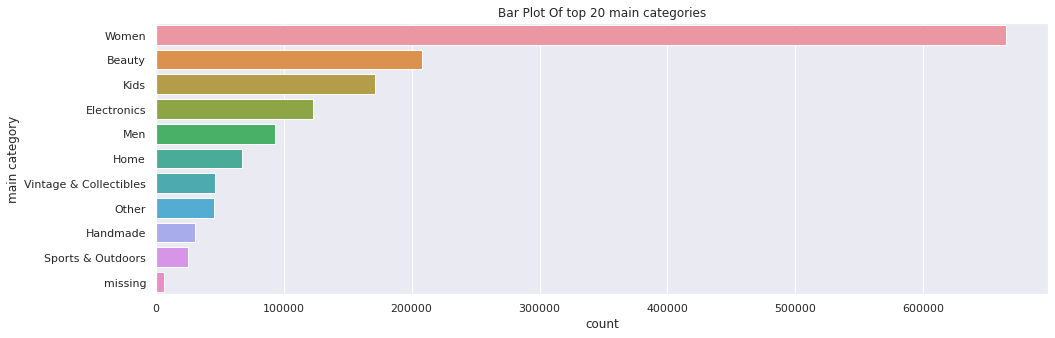

In [81]:
count=data['main_category'].value_counts()
print("Number of unique main categories",len(count))
plt.figure(figsize=(16,5))
sns.barplot(count[0:19],count.index[0:19])
plt.title("Bar Plot Of top 20 main categories")
plt.xlabel('count')
plt.ylabel('main category')
plt.show()

There are 10 unique categories and 11th are the missing values.Top category is women,beauty which means that most of the products are for womem.Lets see how price changes wrt main category

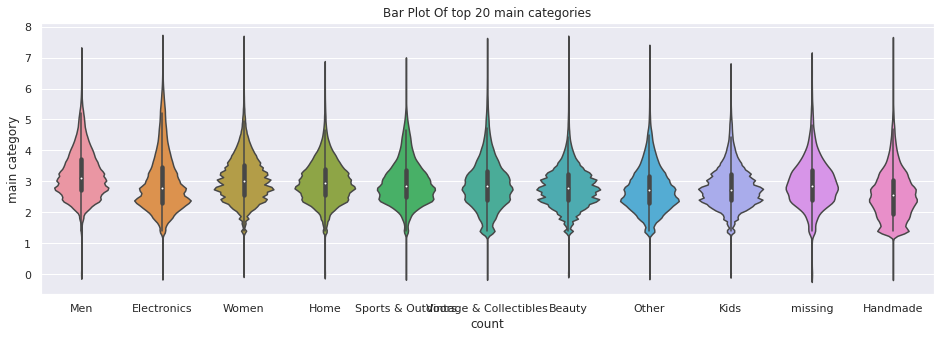

In [82]:
plt.figure(figsize=(16,5))
sns.violinplot(x=data['main_category'], y=np.log(data['price']+1))
plt.title("Bar Plot Of top 20 main categories")
plt.xlabel('count')
plt.ylabel('main category')
plt.show()

There average prices are almost same.

#EDA on sub_category1

In [83]:
data["sub_category1"].fillna("missing", inplace=True)
print("Number of Missing Values in sub_category1 : ", data.sub_category1.isnull().sum())

Number of Missing Values in sub_category1 :  0


Number of unique sub categories1 114


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


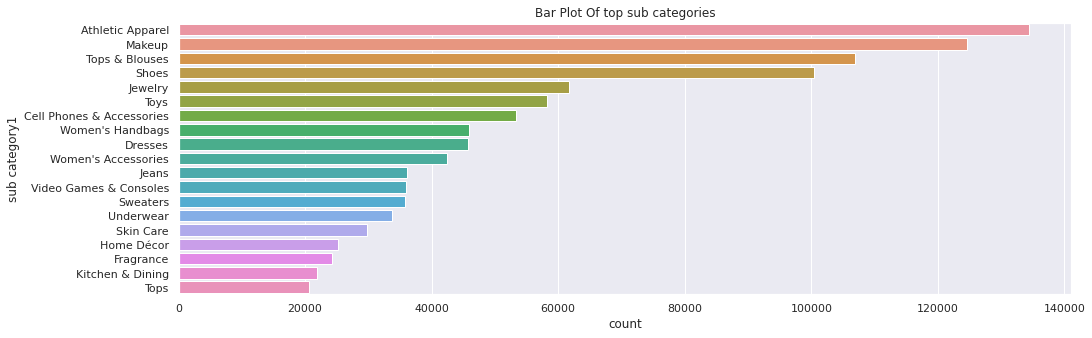

In [84]:
count=data['sub_category1'].value_counts()
print("Number of unique sub categories1",len(count))
plt.figure(figsize=(16,5))
sns.barplot(count[0:19],count.index[0:19])
plt.title("Bar Plot Of top sub categories")
plt.xlabel('count')
plt.ylabel('sub category1')
plt.show()

Most of the datapoints are of sub category athletic apparel,makeup etc.

Number of unique sub categories2 871


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


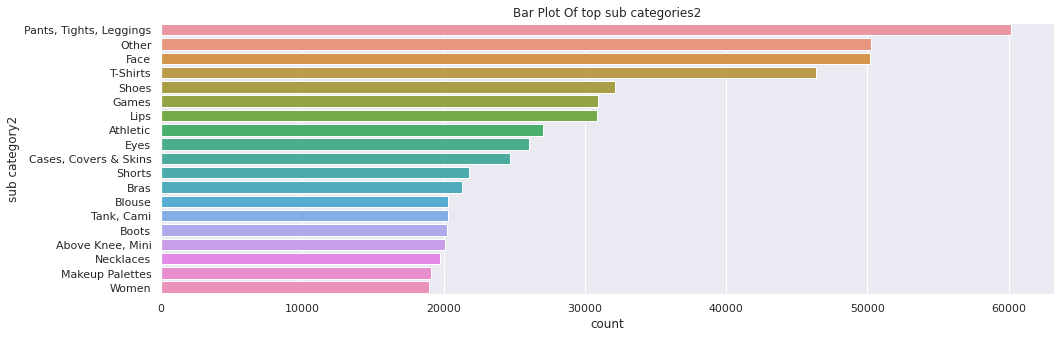

In [85]:
count=data['sub_category2'].value_counts()
print("Number of unique sub categories2",len(count))
plt.figure(figsize=(16,5))
sns.barplot(count[0:19],count.index[0:19])
plt.title("Bar Plot Of top sub categories2")
plt.xlabel('count')
plt.ylabel('sub category2')
plt.show()

Most of the sub_category2 of the datapoints are pants,tights,leggings.Some features are have other as subcategory2 but there prior category are not strictly other

##EDA on name

1.   Name of the item
2.   Does not contain any NaN values



In [86]:
data['name'][0:20]

0        MLB Cincinnati Reds T Shirt Size XL
1           Razer BlackWidow Chroma Keyboard
2                             AVA-VIV Blouse
3                      Leather Horse Statues
4                       24K GOLD plated rose
5           Bundled items requested for Ruie
6         Acacia pacific tides santorini top
7       Girls cheer and tumbling bundle of 7
8                      Girls Nike Pro shorts
9     Porcelain clown doll checker pants VTG
10                           Smashbox primer
11                    New vs pi k body mists
12                        Black Skater dress
13                      Sharpener and eraser
14        HOLD for Dogs2016 Minnetonka boots
15               Sephora tarte birthday gift
16                         Glitter Eyeshadow
17       New: Baby K'tan active baby carrier
18       Too Faced Limited "Merry Macaroons"
19            Cream/ Beige Front Cross Shirt
Name: name, dtype: object

In [87]:
names_list=list(data['name'])
all_names=" ".join(names_list)

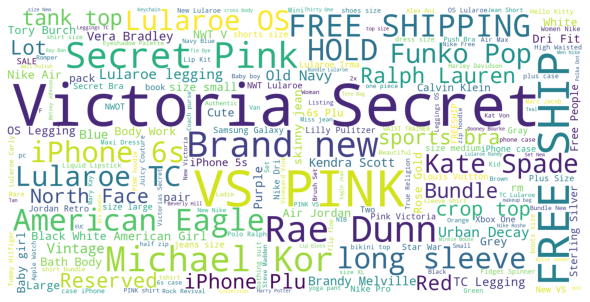

In [88]:
##https://www.geeksforgeeks.org/generating-word-cloud-python/


wordcloud = WordCloud(width = 1600, height = 800, 
                background_color ='white', 
                min_font_size = 10).generate(all_names) 

# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

It can be seen that the name contains item brands,also the word "bundle" shows that some items are sold in bundles and are priced more than a single item,we will see if it degrades the model.

In [93]:
name_high_prices = list(data['name'].loc[data['price'] > 29])
all_names =" ".join( name_high_prices)

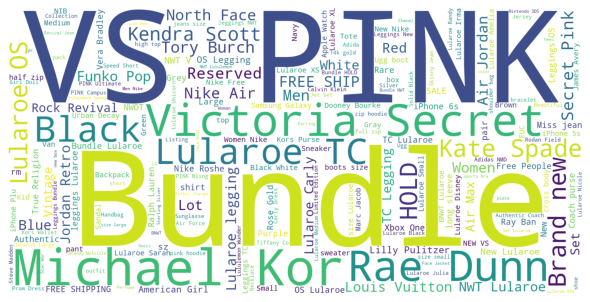

In [94]:
##https://www.geeksforgeeks.org/generating-word-cloud-python/


wordcloud = WordCloud(width = 1600, height = 800, 
                background_color ='white', 
                min_font_size = 10).generate(all_names) 

# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

##EDA on item_description


1.   4 items have missing descriptions
2.   Around 82000 item have description as "No description yet"

So lets convert missing values to no description yet.







In [89]:
data["item_description"].fillna("No description yet", inplace=True)
print("Number of Missing Values in item_description : ", data.sub_category1.isnull().sum())

Number of Missing Values in item_description :  0


In [90]:
description_list=list(data['item_description'])
all_descriptions=" ".join(description_list)

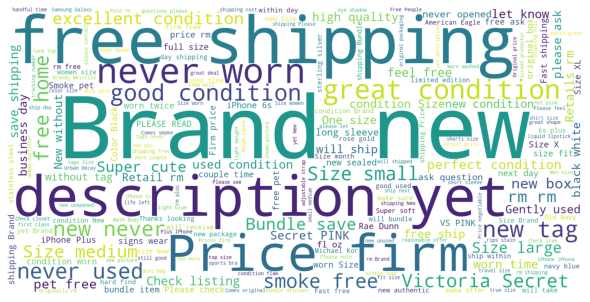

In [51]:
wordcloud = WordCloud(width = 1600, height = 800, 
                background_color ='white', 
                min_font_size = 10).generate(all_descriptions) 

# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

Most common words in the description  appear to be brand,new,free shipping and since a large number of the mdont have any description so "description" ,"yet" also appear in the word cloud

In [91]:
description_high_prices = list(data['item_description'].loc[data['price'] > 29])
all_descriptions=" ".join(description_high_prices)

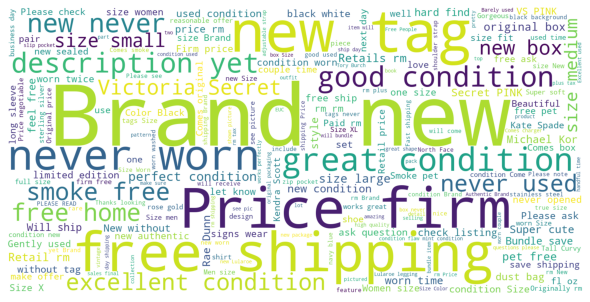

In [92]:
wordcloud = WordCloud(width = 1600, height = 800, 
                background_color ='white', 
                min_font_size = 10).generate(all_descriptions) 

# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

##Sentiment Analysis of item_description

*   It is needed to be done before text preprocessing.
*   A sentiment value of "GOOD" is different from "good"



In [95]:
#https://github.com/oin156/Mercari-Price-Suggestion-Challenge/blob/master/MercariPrice.ipynb

sentiment_analyser=SentimentIntensityAnalyzer()

train_sentiment_description=[]
train_sentiment_name=[]

for descriptions in tqdm(data['item_description'].values):
    ss = sentiment_analyser.polarity_scores(descriptions)
    train_sentiment_description.append(ss)

for name in tqdm(data['name'].values):
    ss = sentiment_analyser.polarity_scores(name)
    train_sentiment_name.append(ss) 


100%|██████████| 1482535/1482535 [01:27<00:00, 16974.29it/s]


In [97]:
negative_description=[]
neutral_description=[]
positive_description=[]
compounding_description=[]
for i in train_sentiment_description: 
    for polarity,score in i.items():
        if(polarity=='neg'):
            negative_description.append(score)
        if(polarity=='neu'):
            neutral_description.append(score)
        if(polarity=='pos'):
            positive_description.append(score)
        if(polarity=='compound'):
            compounding_description.append(score)

In [98]:
data['negative_description']=negative_description
data['neutral_description']=neutral_description
data['positive_description']=positive_description
data['compound_description']=compounding_description

In [99]:
negative_name=[]
neutral_name=[]
positive_name=[]
compounding_name=[]
for i in train_sentiment_name: 
    for polarity,score in i.items():
        if(polarity=='neg'):
            negative_name.append(score)
        if(polarity=='neu'):
            neutral_name.append(score)
        if(polarity=='pos'):
            positive_name.append(score)
        if(polarity=='compound'):
            compounding_name.append(score)

In [100]:
data['negative_name']=negative_name
data['neutral_name']=neutral_name
data['positive_name']=positive_name
data['compound_name']=compounding_name

In [101]:
data

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,main_category,sub_category1,sub_category2,negative_description,neutral_description,positive_description,compound_description,negative_name,neutral_name,positive_name,compound_name
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,missing,10.0,1,No description yet,Men,Tops,T-shirts,0.524,0.476,0.000,-0.2960,0.0,1.000,0.000,0.0000
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...,Electronics,Computers & Tablets,Components & Parts,0.000,0.753,0.247,0.8957,0.0,1.000,0.000,0.0000
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...,Women,Tops & Blouses,Blouse,0.000,0.798,0.202,0.6792,0.0,1.000,0.000,0.0000
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,missing,35.0,1,New with tags. Leather horses. Retail for [rm]...,Home,Home Décor,Home Décor Accents,0.000,0.833,0.167,0.6808,0.0,1.000,0.000,0.0000
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,missing,44.0,0,Complete with certificate of authenticity,Women,Jewelry,Necklaces,0.000,1.000,0.000,0.0000,0.0,1.000,0.000,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1482530,1482530,Free People Inspired Dress,2,Women/Dresses/Mid-Calf,Free People,20.0,1,"Lace, says size small but fits medium perfectl...",Women,Dresses,Mid-Calf,0.208,0.504,0.287,0.5874,0.0,0.235,0.765,0.7579
1482531,1482531,Little mermaid handmade dress,2,Kids/Girls 2T-5T/Dresses,Disney,14.0,0,Little mermaid handmade dress never worn size 2t,Kids,Girls 2T-5T,Dresses,0.000,0.788,0.212,0.2235,0.0,1.000,0.000,0.0000
1482532,1482532,21 day fix containers and eating plan,2,Sports & Outdoors/Exercise/Fitness accessories,missing,12.0,0,"Used once or twice, still in great shape.",Sports & Outdoors,Exercise,Fitness accessories,0.000,0.631,0.369,0.6249,0.0,1.000,0.000,0.0000
1482533,1482533,World markets lanterns,3,Home/Home Décor/Home Décor Accents,missing,45.0,1,There is 2 of each one that you see! So 2 red ...,Home,Home Décor,Home Décor Accents,0.000,1.000,0.000,0.0000,0.0,1.000,0.000,0.0000


##Count number of stopwords in description

1.   This also needs to be done before preprocessing as in preprocessing we would remove stopwords



In [102]:
all_stopwords= set(stopwords.words('english'))
def number_of_stopwords(data):
  """this function counts the number of stopwords in each of the item_description"""
  count_stopwords=[]
  for i in tqdm(data['item_description'].values):
    count=0
    for j in i.split(' '):
      if j in all_stopwords:
        count+=1
    count_stopwords.append(count)
  return count_stopwords

In [103]:
data['count_stopwords']=number_of_stopwords(data)
print(data['count_stopwords'])

100%|██████████| 1482535/1482535 [00:05<00:00, 251870.60it/s]


0           0
1          15
2          13
3          10
4           2
           ..
1482530     4
1482531     0
1482532     3
1482533    11
1482534     3
Name: count_stopwords, Length: 1482535, dtype: int64


##Data Preprocessing.

1.   Convert Price to log(price+1)
2.   Fill the missing values in all features with appropriate values.
3.   Drop duplicate values
4.   Text Preprocessing on item description and name
2.   List item





In [104]:
#because the allowed range for item prices at mercari is between 5 dollars to 2000 dollars
mask1 = (data['price']>5)
mask2 = (data['price']<=2000)
data_new=data[mask1]
data_new2=data_new[mask2]
data=data_new2

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """


In [105]:
data['price']=np.log(data['price']+1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [106]:
data["category_name"].fillna("missing", inplace=True)
print("Number of Missing Values in Category Name : ", data['category_name'].isnull().sum())

data['main_category'],data['sub_category1'],data['sub_category2']=data['category_name'].str.split("/",2).str

data["sub_category1"].fillna("missing", inplace=True)
print("Number of Missing Values in sub_category1 : ", data['sub_category1'].isnull().sum())

data["sub_category2"].fillna("missing", inplace=True)
print("Number of Missing Values in sub_category2 : ", data['sub_category2'].isnull().sum())

data["brand_name"].fillna("missing", inplace=True)
print("Number of Missing Values in brand_name : ", data['brand_name'].isnull().sum())

data["item_description"].fillna("No description yet", inplace=True)
print("Number of Missing Values in item_description : ", data['item_description'].isnull().sum())

/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:4536: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


Number of Missing Values in Category Name :  0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Number of Missing Values in sub_category1 :  0
Number of Missing Values in sub_category2 :  0
Number of Missing Values in brand_name :  0
Number of Missing Values in item_description :  0


In [148]:
test["category_name"].fillna("missing", inplace=True)
print("Number of Missing Values in Category Name : ", test['category_name'].isnull().sum())

test['main_category'],test['sub_category1'],test['sub_category2']=test['category_name'].str.split("/",2).str

test["sub_category1"].fillna("missing", inplace=True)
print("Number of Missing Values in sub_category1 : ", test['sub_category1'].isnull().sum())

test["sub_category2"].fillna("missing", inplace=True)
print("Number of Missing Values in sub_category2 : ", test['sub_category2'].isnull().sum())

test["brand_name"].fillna("missing", inplace=True)
print("Number of Missing Values in brand_name : ", test['brand_name'].isnull().sum())

test["item_description"].fillna("No description yet", inplace=True)
print("Number of Missing Values in item_description : ", test['item_description'].isnull().sum())

Number of Missing Values in Category Name :  0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  after removing the cwd from sys.path.


Number of Missing Values in sub_category1 :  0
Number of Missing Values in sub_category2 :  0
Number of Missing Values in brand_name :  0
Number of Missing Values in item_description :  0


In [149]:
a=0
missing_brand_indexes_before_filling_test = []
for i in list(test['brand_name']):
  if i=="missing":
    missing_brand_indexes_before_filling_test.append(a)
  a += 1

print(len(missing_brand_indexes_before_filling_test))

1476490


In [107]:
a=0
missing_brand_indexes_before_filling = []
for i in list(data['brand_name']):
  if i=="missing":
    missing_brand_indexes_before_filling.append(a)
  a += 1


In [108]:
# inspired from https://www.kaggle.com/gspmoreira/cnn-glove-single-model-private-lb-0-41117-35th
def concat_categories(x):
        return set(x.values)

def brand_guesser(df):
    """
    Description:
    This function is used to guess the missing brand name.
    It will check for an existing brand name mentioned in the item name section. 
    We want out guess to be as close to actual as possible, \
    hence we will also check the category of the brand name that is guessed with the already mentioned category of that product. 
    If the category matches, then only we will fill that guessed brand name.

    Inputs: dataframe with missing brand names
    Output: dataframe with filled brand names
    """
    existing_brands = df[df['brand_name'] != 'missing']['brand_name'].unique()
    brand_names_categories = dict(df[df['brand_name'] != 'missing'][['brand_name','category_name']].astype('str').groupby('brand_name').agg(concat_categories).reset_index().values.tolist())
    # In the above line, we are creating dictionary of brand name->category, wherever the brand name is missing.
    # This will be helpful to us during guessing the missing brand names.
    filled_brands = []
    for row in tqdm(df[['brand_name','name','category_name']].values):
        found=False
        if row[0]=='missing':
            for brand in existing_brands:
                if brand in row[1] and row[2] in brand_names_categories[brand] :
                    filled_brands.append(brand)
                    found=True
                    break
            if not found:
                filled_brands.append('missing')
        else:
            filled_brands.append(row[0])

    df['brand_name']=filled_brands
    return df

In [109]:
data = brand_guesser(data)

100%|██████████| 1415314/1415314 [06:10<00:00, 3817.79it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [110]:
a=0
missing_brand_indexes_after_filling = []
for i in list(data['brand_name']):
  if i=="missing":
    missing_brand_indexes_after_filling.append(a)
  a += 1


In [115]:
indexes_filled = list(set(missing_brand_indexes_before_filling) - set(missing_brand_indexes_after_filling))
print(len(missing_brand_indexes_before_filling) , len(missing_brand_indexes_after_filling), len(indexes_filled ))

586955 496013 90942


In [118]:
data.iloc[indexes_filled[2]]

train_id                                                           274419
name                                    3D Fiber Lash Mascara by Younique
item_condition_id                                                       1
category_name                                          Beauty/Makeup/Eyes
brand_name                                                       Younique
price                                                             2.77259
shipping                                                                1
item_description        Brand New 2 Piece Mascara Box - Black Color Po...
main_category                                                      Beauty
sub_category1                                                      Makeup
sub_category2                                                        Eyes
negative_description                                                    0
neutral_description                                                     1
positive_description                  

In [119]:
data.shape

(1415314, 20)

In [150]:
test = brand_guesser(test)

100%|██████████| 3460725/3460725 [15:41<00:00, 3674.15it/s]


In [156]:
a=0
missing_brand_indexes_after_filling_test=[]
for i in list(test['brand_name']):
  if i=="missing":
    missing_brand_indexes_after_filling_test.append(a)
  a += 1

print(len(missing_brand_indexes_after_filling_test))

1233564


In [158]:
indexes_filled_test = list(set(missing_brand_indexes_before_filling_test) - set(missing_brand_indexes_after_filling_test))
print(len(missing_brand_indexes_before_filling_test) , len(missing_brand_indexes_after_filling_test), len(indexes_filled_test ))

1476490 1233564 242926


In [ ]:
# printing some random reviews
sent_0 = final['item_description'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['item_description'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['item_description'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['item_description'].values[4900]
print(sent_4900)
print("="*50)

No description yet
LAST 1! / Guaranteed authentic 38S7CTTT2L / Retail: [rm] / Model: JET SET / ITEM MD TOTE / Coral Reef / Genuine leather / Gold hardware 14 long / 16 Tall / 14 wide open (Large) Rare find / New with Michael kors care card and UPC tag / UPC: 190864437682 / FREE usps Shipping and tracking / Shipped same business day
Used Odyssey Metal X 8 with headcover. Putter is 32" at address. Good used shape with a few dings ! Look at my other listings!
No description yet


In [120]:
data.head(5)

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,main_category,sub_category1,sub_category2,negative_description,neutral_description,positive_description,compound_description,negative_name,neutral_name,positive_name,compound_name,count_stopwords
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,MLB,2.397895,1,No description yet,Men,Tops,T-shirts,0.524,0.476,0.000,-0.2960,0.0,1.0,0.0,0.0,0
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,3.970292,0,This keyboard is in great condition and works ...,Electronics,Computers & Tablets,Components & Parts,0.000,0.753,0.247,0.8957,0.0,1.0,0.0,0.0,15
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,2.397895,1,Adorable top with a hint of lace and a key hol...,Women,Tops & Blouses,Blouse,0.000,0.798,0.202,0.6792,0.0,1.0,0.0,0.0,13
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,missing,3.583519,1,New with tags. Leather horses. Retail for [rm]...,Home,Home Décor,Home Décor Accents,0.000,0.833,0.167,0.6808,0.0,1.0,0.0,0.0,10
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,missing,3.806662,0,Complete with certificate of authenticity,Women,Jewelry,Necklaces,0.000,1.000,0.000,0.0000,0.0,1.0,0.0,0.0,2


In [121]:
all_stopwords=set(stopwords.words('english'))

In [122]:
# https://stackoverflow.com/a/47091490/4084039
#applied ai course


def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [123]:
# https://gist.github.com/sebleier/554280
def text_preprocessing(data):
  """this function performs preprocessing the item_description """
  preprocessed_total = []
  for sentance in tqdm(data):
    sent = decontracted(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    sent = ' '.join(e for e in sent.split() if e.lower() not in all_stopwords) #removing stop words
    preprocessed_total.append(sent.lower().strip())
  return preprocessed_total


In [124]:
preprocessed__descriptions=text_preprocessing(data['item_description'])

100%|██████████| 1415314/1415314 [00:33<00:00, 42500.84it/s]


In [125]:
data['item_description']=preprocessed__descriptions
data

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,main_category,sub_category1,sub_category2,negative_description,neutral_description,positive_description,compound_description,negative_name,neutral_name,positive_name,compound_name,count_stopwords
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,MLB,2.397895,1,description yet,Men,Tops,T-shirts,0.524,0.476,0.000,-0.2960,0.0,1.000,0.000,0.0000,0
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,3.970292,0,keyboard great condition works like came box p...,Electronics,Computers & Tablets,Components & Parts,0.000,0.753,0.247,0.8957,0.0,1.000,0.000,0.0000,15
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,2.397895,1,adorable top hint lace key hole back pale pink...,Women,Tops & Blouses,Blouse,0.000,0.798,0.202,0.6792,0.0,1.000,0.000,0.0000,13
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,missing,3.583519,1,new tags leather horses retail rm stand foot h...,Home,Home Décor,Home Décor Accents,0.000,0.833,0.167,0.6808,0.0,1.000,0.000,0.0000,10
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,missing,3.806662,0,complete certificate authenticity,Women,Jewelry,Necklaces,0.000,1.000,0.000,0.0000,0.0,1.000,0.000,0.0000,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1482530,1482530,Free People Inspired Dress,2,Women/Dresses/Mid-Calf,Free People,3.044522,1,lace says size small fits medium perfectly nev...,Women,Dresses,Mid-Calf,0.208,0.504,0.287,0.5874,0.0,0.235,0.765,0.7579,4
1482531,1482531,Little mermaid handmade dress,2,Kids/Girls 2T-5T/Dresses,Disney,2.708050,0,little mermaid handmade dress never worn size 2t,Kids,Girls 2T-5T,Dresses,0.000,0.788,0.212,0.2235,0.0,1.000,0.000,0.0000,0
1482532,1482532,21 day fix containers and eating plan,2,Sports & Outdoors/Exercise/Fitness accessories,missing,2.564949,0,used twice still great shape,Sports & Outdoors,Exercise,Fitness accessories,0.000,0.631,0.369,0.6249,0.0,1.000,0.000,0.0000,3
1482533,1482533,World markets lanterns,3,Home/Home Décor/Home Décor Accents,missing,3.828641,1,2 one see 2 red 2 orange 2 big red orange ones...,Home,Home Décor,Home Décor Accents,0.000,1.000,0.000,0.0000,0.0,1.000,0.000,0.0000,11


In [126]:
preprocessed_name=text_preprocessing(data['name'])

100%|██████████| 1415314/1415314 [00:16<00:00, 88163.12it/s]


In [127]:
preprocessed_name

['mlb cincinnati reds shirt size xl',
 'razer blackwidow chroma keyboard',
 'ava viv blouse',
 'leather horse statues',
 '24k gold plated rose',
 'bundled items requested ruie',
 'acacia pacific tides santorini top',
 'girls cheer tumbling bundle 7',
 'girls nike pro shorts',
 'porcelain clown doll checker pants vtg',
 'smashbox primer',
 'new vs pi k body mists',
 'black skater dress',
 'hold dogs2016 minnetonka boots',
 'sephora tarte birthday gift',
 'glitter eyeshadow',
 'new baby k notan active baby carrier',
 'faced limited merry macaroons',
 'cream beige front cross shirt',
 'torrid nautical peplum tube top',
 'nwt vs ultimate sports bra 34ddd',
 'galaxy s7 edge unlocked 32gb',
 'triple car charger',
 'black red baseball tee',
 'air jordan carmine 6s',
 'otterbox defender iphone 6 plus 6s plus',
 'lularoe os black white polka dots',
 'kendra bundle',
 'faced better sex mascara qty3',
 'new lularoe os leggings stars',
 'pink bra 36d',
 'caudal e beauty elixir spray',
 'black capr

In [130]:
data['name']=preprocessed_name

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [159]:
preprocessed__descriptions=text_preprocessing(test['item_description'])
test['item_description']=preprocessed__descriptions

preprocessed_name=text_preprocessing(test['name'])
test['name']=preprocessed_name

100%|██████████| 3460725/3460725 [00:40<00:00, 84958.04it/s]


# Feature Engineering

1.   length of text features ie name and item_description
2.   if item is branded or not





## 1.Length of text features

In [131]:
def text_feature_length(data):
  """This function computes the length of text features"""
  list_of_length=[]
  for sentence in tqdm(data):
      length_value=len(sentence.split(" "))
      list_of_length.append(length_value)
  return list_of_length

In [132]:
data['description_length']=text_feature_length(data['item_description'])
data['name_length']=text_feature_length(data['name'])

100%|██████████| 1415314/1415314 [00:01<00:00, 769095.56it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
100%|██████████| 1415314/1415314 [00:00<00:00, 1474969.26it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


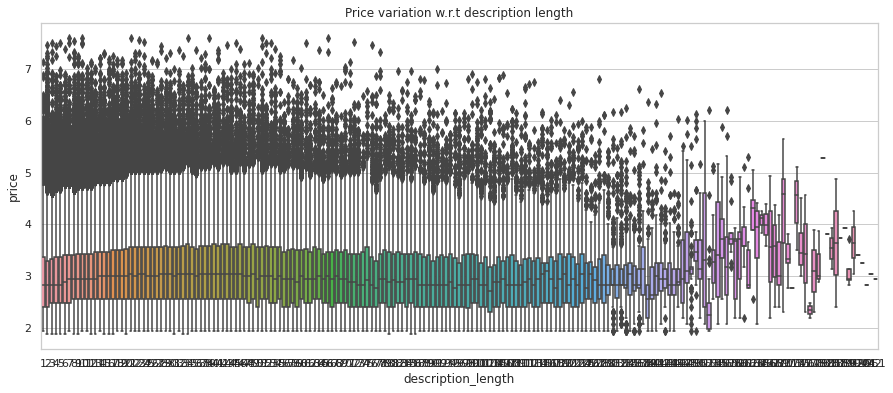

In [133]:
sns.set(style='whitegrid')
plt.figure(figsize=(15,6))
sns.boxplot(x=data['description_length'], y=data['price'])
plt.title('Price variation w.r.t description length')
plt.show()

We can see that as mean prices do not change much with description length but most of the high priced item have small description length.

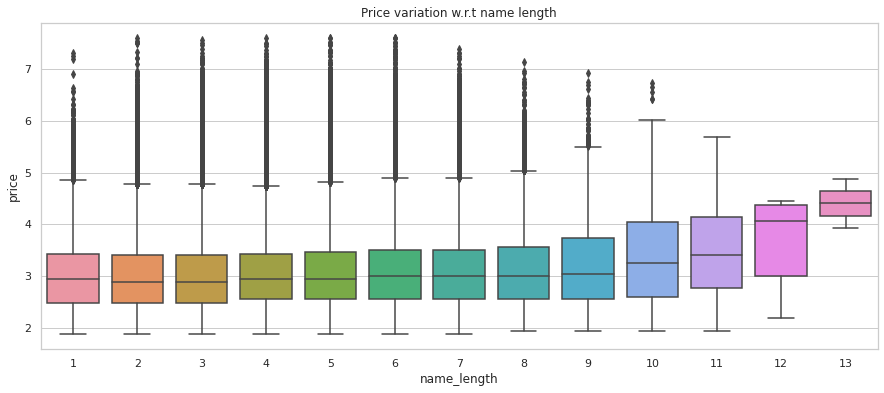

In [134]:
sns.set(style='whitegrid')
plt.figure(figsize=(15,6))
sns.boxplot(x=data['name_length'], y=data['price'])
plt.title('Price variation w.r.t name length')
plt.show()

We can see that means prices increase slightly as name length increases.

#2.If branded or not

1.     0 if brand_name is nnot present
2.     1 if brand_name is present


In [135]:
def branded_or_not(data):
  brand_known_or_not=[]
  """This function checks if brand name is missing or not"""
  for brands in tqdm(data):
    if brands=="missing":
      brand_known_or_not.append(0)
    else:
      brand_known_or_not.append(1)
  return brand_known_or_not


In [136]:
data['brand_known_or_not']=branded_or_not(data['brand_name'])
data

100%|██████████| 1415314/1415314 [00:00<00:00, 2496641.57it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,main_category,sub_category1,sub_category2,negative_description,neutral_description,positive_description,compound_description,negative_name,neutral_name,positive_name,compound_name,count_stopwords,description_length,name_length,brand_known_or_not
0,0,mlb cincinnati reds shirt size xl,3,Men/Tops/T-shirts,MLB,2.397895,1,description yet,Men,Tops,T-shirts,0.524,0.476,0.000,-0.2960,0.0,1.000,0.000,0.0000,0,2,6,1
1,1,razer blackwidow chroma keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,3.970292,0,keyboard great condition works like came box p...,Electronics,Computers & Tablets,Components & Parts,0.000,0.753,0.247,0.8957,0.0,1.000,0.000,0.0000,15,18,4,1
2,2,ava viv blouse,1,Women/Tops & Blouses/Blouse,Target,2.397895,1,adorable top hint lace key hole back pale pink...,Women,Tops & Blouses,Blouse,0.000,0.798,0.202,0.6792,0.0,1.000,0.000,0.0000,13,14,3,1
3,3,leather horse statues,1,Home/Home Décor/Home Décor Accents,missing,3.583519,1,new tags leather horses retail rm stand foot h...,Home,Home Décor,Home Décor Accents,0.000,0.833,0.167,0.6808,0.0,1.000,0.000,0.0000,10,18,3,0
4,4,24k gold plated rose,1,Women/Jewelry/Necklaces,missing,3.806662,0,complete certificate authenticity,Women,Jewelry,Necklaces,0.000,1.000,0.000,0.0000,0.0,1.000,0.000,0.0000,2,3,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1482530,1482530,free people inspired dress,2,Women/Dresses/Mid-Calf,Free People,3.044522,1,lace says size small fits medium perfectly nev...,Women,Dresses,Mid-Calf,0.208,0.504,0.287,0.5874,0.0,0.235,0.765,0.7579,4,16,4,1
1482531,1482531,little mermaid handmade dress,2,Kids/Girls 2T-5T/Dresses,Disney,2.708050,0,little mermaid handmade dress never worn size 2t,Kids,Girls 2T-5T,Dresses,0.000,0.788,0.212,0.2235,0.0,1.000,0.000,0.0000,0,8,4,1
1482532,1482532,21 day fix containers eating plan,2,Sports & Outdoors/Exercise/Fitness accessories,missing,2.564949,0,used twice still great shape,Sports & Outdoors,Exercise,Fitness accessories,0.000,0.631,0.369,0.6249,0.0,1.000,0.000,0.0000,3,5,6,0
1482533,1482533,world markets lanterns,3,Home/Home Décor/Home Décor Accents,missing,3.828641,1,2 one see 2 red 2 orange 2 big red orange ones...,Home,Home Décor,Home Décor Accents,0.000,1.000,0.000,0.0000,0.0,1.000,0.000,0.0000,11,14,3,0


We had seen tha price depends a lot on brand so one feature could be the average price of the items brand.

On Grouping Category Name, Brand Name and Shipping we will create 8 new features
with respect to Price like Price_Mean, Price_Median, Price_Std_Deviation, Minimum and
Maximum Price per group

In [167]:
data['cat_brand_ship'] = (data['main_category'].astype(str) + "/" + 
                          data['sub_category1'].astype(str) + "/" +
                          data['sub_category2'].astype(str) + "_" +
                          data['brand_name'].astype(str) + "_" +  
                          data['shipping'].astype(str))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [171]:
test['cat_brand_ship'] = (test['main_category'].astype(str) + "/" + 
                          test['sub_category1'].astype(str) + "/" +
                          test['sub_category2'].astype(str) + "_" +
                          test['brand_name'].astype(str) + "_" +  
                          test['shipping'].astype(str))

In [140]:
data.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,main_category,sub_category1,sub_category2,negative_description,neutral_description,positive_description,compound_description,negative_name,neutral_name,positive_name,compound_name,count_stopwords,description_length,name_length,brand_known_or_not,cat_brand_ship
0,0,mlb cincinnati reds shirt size xl,3,Men/Tops/T-shirts,MLB,2.397895,1,description yet,Men,Tops,T-shirts,0.524,0.476,0.000,-0.2960,0.0,1.0,0.0,0.0,0,2,6,1,Men/Tops/T-shirts_MLB_1
1,1,razer blackwidow chroma keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,3.970292,0,keyboard great condition works like came box p...,Electronics,Computers & Tablets,Components & Parts,0.000,0.753,0.247,0.8957,0.0,1.0,0.0,0.0,15,18,4,1,Electronics/Computers & Tablets/Components & P...
2,2,ava viv blouse,1,Women/Tops & Blouses/Blouse,Target,2.397895,1,adorable top hint lace key hole back pale pink...,Women,Tops & Blouses,Blouse,0.000,0.798,0.202,0.6792,0.0,1.0,0.0,0.0,13,14,3,1,Women/Tops & Blouses/Blouse_Target_1
3,3,leather horse statues,1,Home/Home Décor/Home Décor Accents,missing,3.583519,1,new tags leather horses retail rm stand foot h...,Home,Home Décor,Home Décor Accents,0.000,0.833,0.167,0.6808,0.0,1.0,0.0,0.0,10,18,3,0,Home/Home Décor/Home Décor Accents_missing_1
4,4,24k gold plated rose,1,Women/Jewelry/Necklaces,missing,3.806662,0,complete certificate authenticity,Women,Jewelry,Necklaces,0.000,1.000,0.000,0.0000,0.0,1.0,0.0,0.0,2,3,4,0,Women/Jewelry/Necklaces_missing_0


In [144]:
new_df = data[['price','name_length','negative_description','neutral_description','positive_description','compound_description','negative_name','neutral_name','positive_name','compound_name','count_stopwords','description_length','name_length','brand_known_or_not']]

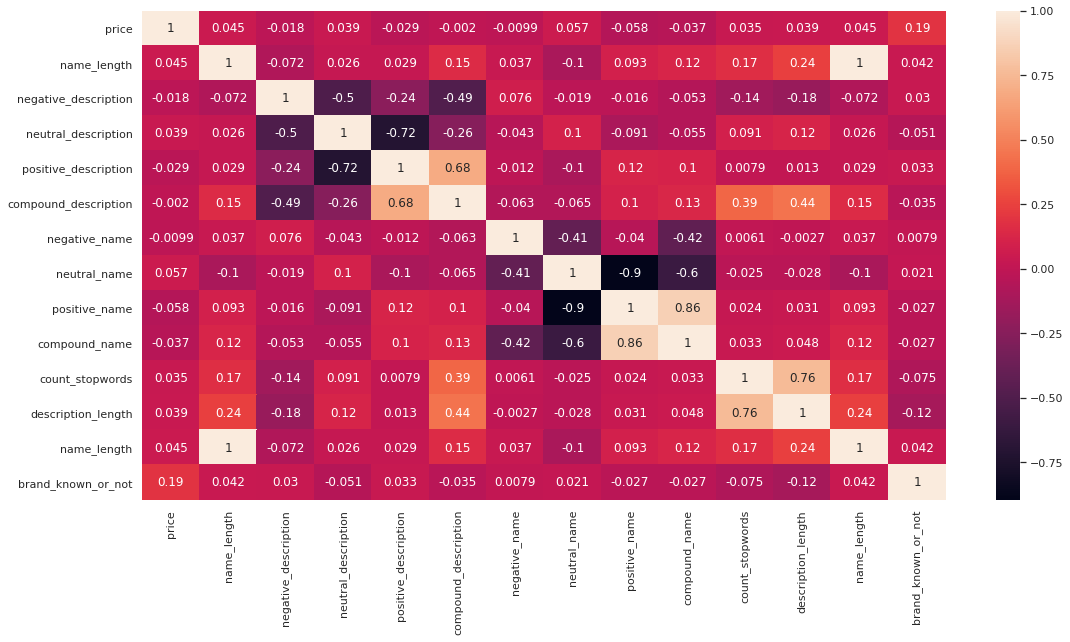

In [145]:
correlation_matrix = new_df.corr()
plt.figure(figsize = (18,9))
sns.heatmap(correlation_matrix, annot=True)
plt.show()

Only branded_or_not ia relevent

In [160]:
data.drop(['name_length','negative_description','neutral_description','positive_description','compound_description','negative_name','neutral_name','positive_name','compound_name','count_stopwords','description_length','name_length'],axis = 1, inplace = True)
data.shape

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


(1415314, 13)

In [168]:
data.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,main_category,sub_category1,sub_category2,brand_known_or_not,cat_brand_ship
0,0,mlb cincinnati reds shirt size xl,3,Men/Tops/T-shirts,MLB,2.397895,1,description yet,Men,Tops,T-shirts,1,Men/Tops/T-shirts_MLB_1
1,1,razer blackwidow chroma keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,3.970292,0,keyboard great condition works like came box p...,Electronics,Computers & Tablets,Components & Parts,1,Electronics/Computers & Tablets/Components & P...
2,2,ava viv blouse,1,Women/Tops & Blouses/Blouse,Target,2.397895,1,adorable top hint lace key hole back pale pink...,Women,Tops & Blouses,Blouse,1,Women/Tops & Blouses/Blouse_Target_1
3,3,leather horse statues,1,Home/Home Décor/Home Décor Accents,missing,3.583519,1,new tags leather horses retail rm stand foot h...,Home,Home Décor,Home Décor Accents,0,Home/Home Décor/Home Décor Accents_missing_1
4,4,24k gold plated rose,1,Women/Jewelry/Necklaces,missing,3.806662,0,complete certificate authenticity,Women,Jewelry,Necklaces,0,Women/Jewelry/Necklaces_missing_0


In [161]:
test['brand_known_or_not']=branded_or_not(test['brand_name'])
test.shape

100%|██████████| 3460725/3460725 [00:01<00:00, 2717212.47it/s]


(3460725, 11)

In [172]:
test.head()

,test_id,name,item_condition_id,category_name,brand_name,shipping,item_description,main_category,sub_category1,sub_category2,brand_known_or_not,cat_brand_ship
0,0,breast cancer fight like girl ring,1,Women/Jewelry/Rings,missing,1,size 7,Women,Jewelry,Rings,0,Women/Jewelry/Rings_missing_1
1,1,25 pcs new 7 5 x12 kraft bubble mailers,1,Other/Office supplies/Shipping Supplies,missing,1,25 pcs new 7 5 x12 kraft bubble mailers lined ...,Other,Office supplies,Shipping Supplies,0,Other/Office supplies/Shipping Supplies_missing_1
2,2,coach bag,1,Vintage & Collectibles/Bags and Purses/Handbag,Coach,1,brand new coach bag bought rm coach outlet,Vintage & Collectibles,Bags and Purses,Handbag,1,Vintage & Collectibles/Bags and Purses/Handbag...
3,3,floral kimono,2,Women/Sweaters/Cardigan,missing,0,floral kimono never worn lightweight perfect h...,Women,Sweaters,Cardigan,0,Women/Sweaters/Cardigan_missing_0
4,4,life death,3,Other/Books/Religion & Spirituality,missing,1,rediscovering life loss loved one tony cooke p...,Other,Books,Religion & Spirituality,0,Other/Books/Religion & Spirituality_missing_1


In [173]:
# Reference : https://www.kaggle.com/gspmoreira/cnn-glove-single-model-private-lb-0-41117-35th
def generate_cbs_stats(train,test):
    df_group = train.groupby('cat_brand_ship',as_index = False).agg({"shipping" : len,
                                                        "price" : [np.median, np.mean, np.std,np.min,np.max]})
    df_group.columns = ['cat_brand_ship','cbs_count','cbs_log_price_median','cbs_log_price_mean','cbs_log_price_std',
                    'cbs_log_price_min','cbs_log_price_max']

    df_group['cbs_log_price_std'] = df_group['cbs_log_price_std'].fillna(0)
    df_group['cbs_log_price_conf_variance'] = df_group['cbs_log_price_std'] / df_group['cbs_log_price_mean']
    df_group['cbs_log_count'] = np.log1p(df_group['cbs_count'])
    df_group['cbs_min_expected_log_price'] = (df_group['cbs_log_price_mean'] - (df_group['cbs_log_price_std']*2)).clip(lower=1.0)
    df_group['cbs_max_expected_log_price'] = (df_group['cbs_log_price_mean'] + (df_group['cbs_log_price_std']*2))
    
    df_group_stats = test.merge(df_group.reset_index(),
                                      how = 'left',
                                      on = 'cat_brand_ship')[['cbs_log_count',
                                                              'cbs_log_price_mean',
                                                              'cbs_log_price_std',
                                                              'cbs_log_price_conf_variance',
                                                              'cbs_min_expected_log_price',
                                                              'cbs_max_expected_log_price',
                                                              'cbs_log_price_min',
                                                              'cbs_log_price_max']].fillna(0).values
    
    scaler = StandardScaler(copy=True)
    cbs_feats_scaled = scaler.fit_transform(df_group_stats)
    return cbs_feats_scaled

In [ ]:

train_cbs_features = generate_cbs_stats(data,data)
test_cbs_features = generate_cbs_stats(data,test)
print("New Train CBS Features Shape : ", train_cbs_features.shape)
print("New Test CBS Features Shape : ", test_cbs_features.shape)

In [ ]:
train_cbs_features[:10]

array([[ 1.42839526e+00, -7.48960746e-01,  1.81881704e-01,
         5.86210865e-01, -8.62662687e-01, -4.02280469e-01,
        -6.79321883e-01,  3.55564603e-01],
       [ 4.09658783e-01,  2.35296350e+00,  4.68280212e-01,
        -3.72928806e-01,  1.89264307e+00,  1.83000910e+00,
         2.86323775e-01,  1.75515064e+00],
       [ 5.61200523e-01, -5.91572024e-01, -1.68401946e-02,
         2.59280274e-01, -5.56234890e-01, -4.05149153e-01,
        -3.17805012e-01,  3.49195545e-01],
       [ 9.38773239e-01,  3.32562519e+00,  2.43999713e+00,
         7.95258890e-01,  1.28617992e+00,  3.55482786e+00,
        -3.17805012e-01,  2.12585513e+00],
       [-1.85353461e+00, -6.79651230e-01,  2.17977501e+00,
         2.96033971e+00, -2.15742203e+00,  7.32119856e-01,
        -3.17805012e-01, -1.31081805e+00],
       [ 8.06289339e-01,  8.80714408e-01, -4.03971532e-01,
        -7.19515205e-01,  1.16023316e+00,  3.69526902e-01,
        -3.17805012e-01,  5.08233151e-01],
       [ 1.33600902e+00,  1.305999

In [ ]:
train_data['cbs_log_count']=train_cbs_features[:,0]
train_data['cbs_log_price_mean']=train_cbs_features[:,1]
train_data['cbs_log_price_std']=train_cbs_features[:,2]
train_data['cbs_log_price_conf_variance']=train_cbs_features[:,3]
train_data['cbs_min_expected_log_price']=train_cbs_features[:,4]
train_data['cbs_max_expected_log_price']=train_cbs_features[:,5]
train_data['cbs_log_price_min']=train_cbs_features[:,6]
train_data['cbs_log_price_max']=train_cbs_features[:,7]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

In [ ]:
train_data.head(5)

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,negative_description,neutral_description,positive_description,compound_description,negative_name,neutral_name,positive_name,compound_name,count_stopwords,main_category,sub_category1,sub_category2,description_length,name_length,brand_known_or_not,cat_brand_ship,cbs_log_count,cbs_log_price_mean,cbs_log_price_std,cbs_log_price_conf_variance,cbs_min_expected_log_price,cbs_max_expected_log_price,cbs_log_price_min,cbs_log_price_max
198986,198986,kylie jenner koko k lip kit,1,Beauty/Makeup/Lips,missing,2.772589,1,kylie jenner koko k lip kit would prefer anoth...,0.00,0.944,0.056,0.1531,0.0,1.0,0.0,0.0,25,Beauty,Makeup,Lips,23,6,0,Beauty/Makeup/Lips_missing_1,1.428395,-0.748961,0.181882,0.586211,-0.862663,-0.402280,-0.679322,0.355565
382186,382186,white banded agate harlow,1,Women/Jewelry/Necklaces,Kendra Scott,4.983607,1,nwt white banded agate kendra scott harlow ret...,0.00,1.000,0.000,0.0000,0.0,1.0,0.0,0.0,1,Women,Jewelry,Necklaces,9,4,1,Women/Jewelry/Necklaces_Kendra Scott_1,0.409659,2.352963,0.468280,-0.372929,1.892643,1.830009,0.286324,1.755151
119624,119624,youth lg armour lined long sleeve,3,Kids/Boys (4+)/Top & T-shirts,missing,2.708050,0,black long sleeved lined armour shirt flaws gr...,0.12,0.656,0.224,0.4404,0.0,1.0,0.0,0.0,2,Kids,Boys (4+),Top & T-shirts,11,6,0,Kids/Boys (4+)/Top & T-shirts_missing_0,0.561201,-0.591572,-0.016840,0.259280,-0.556235,-0.405149,-0.317805,0.349196
130526,130526,iphone 6 6s mophie juice pack plus,2,Electronics/Cell Phones & Accessories/Cell Pho...,Apple,4.043051,0,used great condition,0.00,0.423,0.577,0.6249,0.0,1.0,0.0,0.0,0,Electronics,Cell Phones & Accessories,Cell Phones & Smartphones,3,7,1,Electronics/Cell Phones & Accessories/Cell Pho...,0.938773,3.325625,2.439997,0.795259,1.286180,3.554828,-0.317805,2.125855
254832,254832,aveda invati scalp revitalizer,1,Beauty/Hair Care/Hair & Scalp Treatments,Aveda,2.079442,1,new 10 ml sample,0.00,1.000,0.000,0.0000,0.0,1.0,0.0,0.0,0,Beauty,Hair Care,Hair & Scalp Treatments,4,4,1,Beauty/Hair Care/Hair & Scalp Treatments_Aveda_1,-1.853535,-0.679651,2.179775,2.960340,-2.157422,0.732120,-0.317805,-1.310818


In [ ]:
new_df = pd.concat([
                    pd.DataFrame(generate_cbs_stats(train_data,train_data),
                                  columns = ['cbs_log_count','cbs_log_price_mean','cbs_log_price_std',
                                             'cbs_log_price_conf_variance','cbs_min_expected_log_price',
                                             'cbs_max_expected_log_price','cbs_log_price_min','cbs_log_price_max']),
                    train_data[['negative_description','neutral_description','positive_description','compound_description',
                                'negative_name','neutral_name','positive_name','compound_name',
                                'count_stopwords','description_length','name_length']].reset_index(drop = True),
                    train_data['price'].reset_index(drop = True)],axis = 1)

KeyError: ignored

In [ ]:
test_data['cbs_log_count']=test_cbs_features[:,0]
test_data['cbs_log_price_mean']=test_cbs_features[:,1]
test_data['cbs_log_price_std']=test_cbs_features[:,2]
test_data['cbs_log_price_conf_variance']=test_cbs_features[:,3]
test_data['cbs_min_expected_log_price']=test_cbs_features[:,4]
test_data['cbs_max_expected_log_price']=test_cbs_features[:,5]
test_data['cbs_log_price_min']=test_cbs_features[:,6]
test_data['cbs_log_price_max']=test_cbs_features[:,7]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

In [ ]:
test_data.head(5)

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,negative_description,neutral_description,positive_description,compound_description,negative_name,neutral_name,positive_name,compound_name,count_stopwords,main_category,sub_category1,sub_category2,description_length,name_length,brand_known_or_not,cat_brand_ship,cbs_log_count,cbs_log_price_mean,cbs_log_price_std,cbs_log_price_conf_variance,cbs_min_expected_log_price,cbs_max_expected_log_price,cbs_log_price_min,cbs_log_price_max
258026,258026,20000mah portable travel power bank,1,Electronics/Cell Phones & Accessories/Chargers...,missing,3.091042,0,brand new box retails rm 20000mah portable cha...,0.028,0.848,0.124,0.9404,0.0,1.0,0.0,0.0,36,Electronics,Cell Phones & Accessories,Chargers & Cradles,120,5,0,Electronics/Cell Phones & Accessories/Chargers...,-0.245282,-0.151837,0.295687,0.580942,-0.383467,0.000004,0.016055,0.193607
168079,168079,camp collection 1976 ringer tee,2,Women/Tops & Blouses/T-Shirts,Urban Outfitters,3.044522,1,1976 graphic ringer tee camp collection bought...,0.000,0.733,0.267,0.7863,0.0,1.0,0.0,0.0,4,Women,Tops & Blouses,T-Shirts,18,5,1,Women/Tops & Blouses/T-Shirts_Urban Outfitters_1,-1.220828,-0.585886,-0.813821,-0.456400,-0.212356,-0.728813,-0.221630,-1.189012
248742,248742,nike sb p rod shoes,1,Men/Shoes/Athletic,Nike,3.218876,0,men 9 5 nike sb shoes worn,0.268,0.732,0.000,-0.2960,0.0,1.0,0.0,0.0,1,Men,Shoes,Athletic,7,5,1,Men/Shoes/Athletic_Nike_0,1.177613,1.163994,0.513717,-0.081485,1.134432,1.036656,0.413249,1.089677
252669,252669,xlg tee bundle,2,Men/Tops/T-shirts,missing,3.178054,0,8 xlg tee shirts,0.000,1.000,0.000,0.0000,0.0,1.0,0.0,0.0,0,Men,Tops,T-shirts,4,3,0,Men/Tops/T-shirts_missing_0,0.934018,-0.147609,0.082438,0.328836,-0.240062,-0.076435,0.016055,0.469605
63536,63536,2 x 6 feet cables iphone 5 6 7,1,Electronics/Cell Phones & Accessories/Cables &...,missing,2.397895,1,6 feet 2 x brand new sealed compatible iphone ...,0.000,0.752,0.248,0.5106,0.0,1.0,0.0,0.0,1,Electronics,Cell Phones & Accessories,Cables & Adapters,15,9,0,Electronics/Cell Phones & Accessories/Cables &...,0.661907,-0.643666,-0.576838,-0.095884,-0.438648,-0.682406,-0.221630,-0.686047


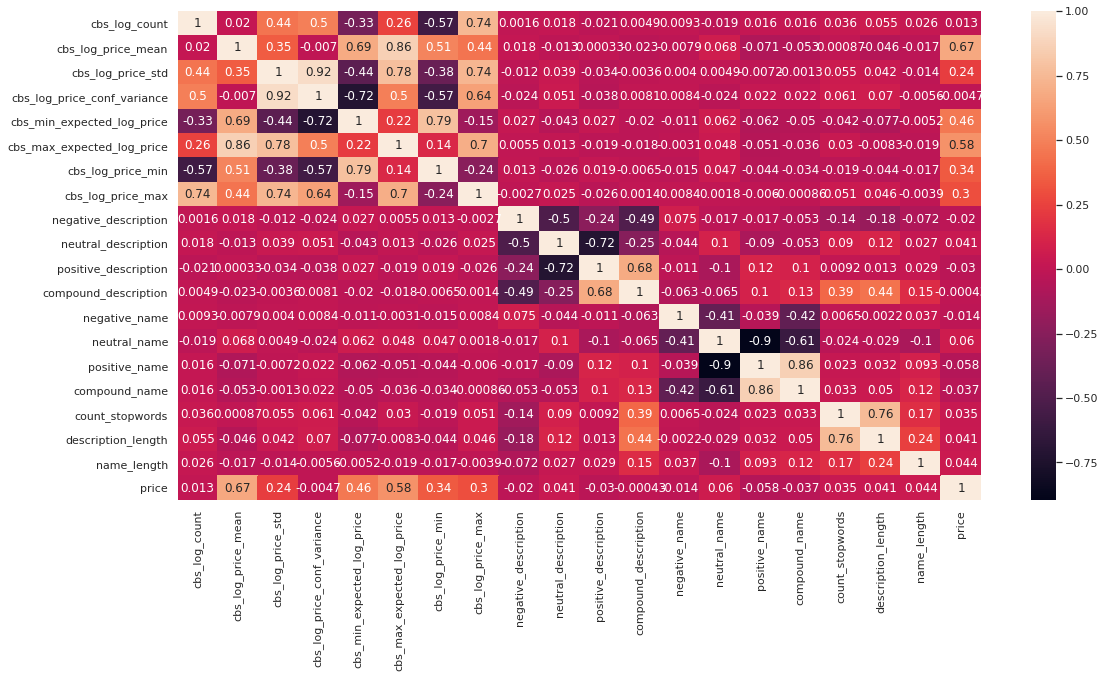

In [ ]:

correlation_matrix = new_df.corr()
plt.figure(figsize = (18,9))
sns.heatmap(correlation_matrix, annot=True)
plt.show()

By observing the last column we notice following features have high correlation with price:

*   cbs_log_price_mean
*   cbs_log_price_std
*   cbs_min_expected_log_price
*   cbs_max_expected_log_price
*   cbs_log_price_max
*   cbs_log_price_min

We will drop all other features

In [ ]:
# Dropping  columns that have low correlation score from training and test data
train_data.drop(['category_name',
                'cat_brand_ship',
                'cbs_log_count',
                'cbs_log_price_conf_variance',
                'negative_description',
                'neutral_description',
                'positive_description',
                'compound_description',
                'negative_name',
                'neutral_name',
                'positive_name',
                'compound_name',
                'count_stopwords',
                'description_length',
                'name_length'],axis = 1, inplace = True)


test_data.drop(['category_name',
                'cat_brand_ship',
                'cbs_log_count',
                'cbs_log_price_conf_variance',
                'negative_description',
                'neutral_description',
                'positive_description',
                'compound_description',
                'negative_name',
                'neutral_name',
                'positive_name',
                'compound_name',
                'count_stopwords',
                'description_length',
                'name_length'],
                axis = 1, inplace = True)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
print(train_data.shape,test_data.shape)
train_data.head(5)

(307308, 17) (102437, 17)


,train_id,name,item_condition_id,brand_name,price,shipping,item_description,main_category,sub_category1,sub_category2,brand_known_or_not,cbs_log_price_mean,cbs_log_price_std,cbs_min_expected_log_price,cbs_max_expected_log_price,cbs_log_price_min,cbs_log_price_max
198986,198986,kylie jenner koko k lip kit,1,missing,2.772589,1,kylie jenner koko k lip kit would prefer anoth...,Beauty,Makeup,Lips,0,-0.748961,0.181882,-0.862663,-0.402280,-0.679322,0.355565
382186,382186,white banded agate harlow,1,Kendra Scott,4.983607,1,nwt white banded agate kendra scott harlow ret...,Women,Jewelry,Necklaces,1,2.352963,0.468280,1.892643,1.830009,0.286324,1.755151
119624,119624,youth lg armour lined long sleeve,3,missing,2.708050,0,black long sleeved lined armour shirt flaws gr...,Kids,Boys (4+),Top & T-shirts,0,-0.591572,-0.016840,-0.556235,-0.405149,-0.317805,0.349196
130526,130526,iphone 6 6s mophie juice pack plus,2,Apple,4.043051,0,used great condition,Electronics,Cell Phones & Accessories,Cell Phones & Smartphones,1,3.325625,2.439997,1.286180,3.554828,-0.317805,2.125855
254832,254832,aveda invati scalp revitalizer,1,Aveda,2.079442,1,new 10 ml sample,Beauty,Hair Care,Hair & Scalp Treatments,1,-0.679651,2.179775,-2.157422,0.732120,-0.317805,-1.310818


In [ ]:
print(test_data.shape)
test_data.head(5)

(102437, 17)


,train_id,name,item_condition_id,brand_name,price,shipping,item_description,main_category,sub_category1,sub_category2,brand_known_or_not,cbs_log_price_mean,cbs_log_price_std,cbs_min_expected_log_price,cbs_max_expected_log_price,cbs_log_price_min,cbs_log_price_max
192718,192718,women size 6 converse shoes,2,missing,3.610918,0,women size 6 converse shoes excellent conditio...,Women,Shoes,Fashion Sneakers,0,0.322642,0.095829,0.342876,0.270173,0.014176,0.483175
187158,187158,dark denim shorts,2,Express,3.044522,0,dark blue denim shorts pockets front gold sail...,Women,Athletic Apparel,Shorts,1,-0.154572,-0.117175,-0.119128,-0.156088,0.223980,-0.201263
249851,249851,starbucks power bank phone charger,1,missing,2.995732,1,free shipping color green portable power bank ...,Electronics,Cell Phones & Accessories,Chargers & Cradles,0,-0.563830,-0.298483,-0.516225,-0.521140,-0.223681,-0.311641
252788,252788,vs pink sequin tee bundle,3,PINK,3.044522,1,burgundy silver sequin white ombr sequin v nec...,Women,Tops & Blouses,T-Shirts,1,0.081048,0.035335,0.078337,0.072080,-0.223681,0.872744
256245,256245,adidas xl hoodie sweather,3,Adidas,2.944439,0,pretty bright blue color pink logo hood great ...,Women,Sweaters,Hooded,1,0.422326,0.529205,0.187652,0.504657,0.411657,-0.053496


In [ ]:
#Save preprocessed file with good features into pickle files
import pickle

file = open("preprocessed_train_data","wb")
pickle.dump(train_data,file)
file.close

file = open("preprocessed_test_data","wb")
pickle.dump(test_data,file)
file.close

<function BufferedWriter.close>